 YOLO 모델을 실행하기 위한 환경을 구성하는 코드입니다.  
필요한 패키지를 설치하고, 이미지 처리 및 데이터 로딩에 필요한 라이브러리를 불러옵니다.

> ✅ 설치 패키지
- `ultralytics`: YOLO 모델 실행 및 학습
- `opencv-python`: 이미지 로딩 및 전처리
- `numpy`, `matplotlib`: 데이터 처리 및 시각화

> ✅ 불러오는 핵심 라이브러리
- `torch`, `torchvision`: 모델 학습 및 데이터 전처리
- `ultralytics.YOLO`: YOLO 모델 로딩
- `cv2`, `numpy`: 이미지 처리 및 수치 계산
- `tqdm`, `matplotlib.pyplot`: 시각화 및 진행 표시

In [1]:
!pip install albumentations --quiet

In [2]:

import os, cv2, torch, yaml, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from ultralytics import YOLO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. 랜덤 시드 고정

실험의 일관성을 유지하기 위해 `random`, `numpy`, `torch`의 시드를 고정합니다.  

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed_everything()

## 3. 데이터 경로 설정 및 YAML 파일 로드
`data.yaml` 파일을 불러와 학습(train), 검증(val) 데이터의 경로를 설정합니다.

> ✅ 학습 데이터는 모델을 학습시키는 데 사용되며,  
> ✅ 검증 데이터는 학습 중 모델의 성능을 평가하고 과적합 여부를 확인하는 데 사용됩니다.

In [4]:
DATA_YAML_PATH = "/app/notebooks/pothole-detection-challenge_convert/data.yaml"

with open(DATA_YAML_PATH, "r", encoding="utf-8") as f:
    data_yaml = yaml.safe_load(f)

DATASET_PATH = os.path.dirname(DATA_YAML_PATH)
TRAIN_IMAGES = os.path.join(DATASET_PATH, data_yaml["train"].replace("../", ""))
VALID_IMAGES = os.path.join(DATASET_PATH, data_yaml["val"].replace("../", ""))

print(DATASET_PATH)
print(TRAIN_IMAGES)
print(VALID_IMAGES)

/app/notebooks/pothole-detection-challenge_convert
/app/notebooks/pothole-detection-challenge_convert/train/images
/app/notebooks/pothole-detection-challenge_convert/valid/images


## 4. 데이터셋 클래스 정의 및 로드  
객체 탐지 모델을 위한 이미지 데이터셋을 생성하고 불러오는 과정입니다.  
OpenCV와 glob을 활용하여 이미지를 로드하고, torchvision.transforms를 적용해  
크기 변환 및 텐서 변환을 수행합니다.  
마지막으로 샘플 이미지를 시각화하여 데이터가 올바르게 불러와졌는지 확인합니다.

훈련 데이터 샘플


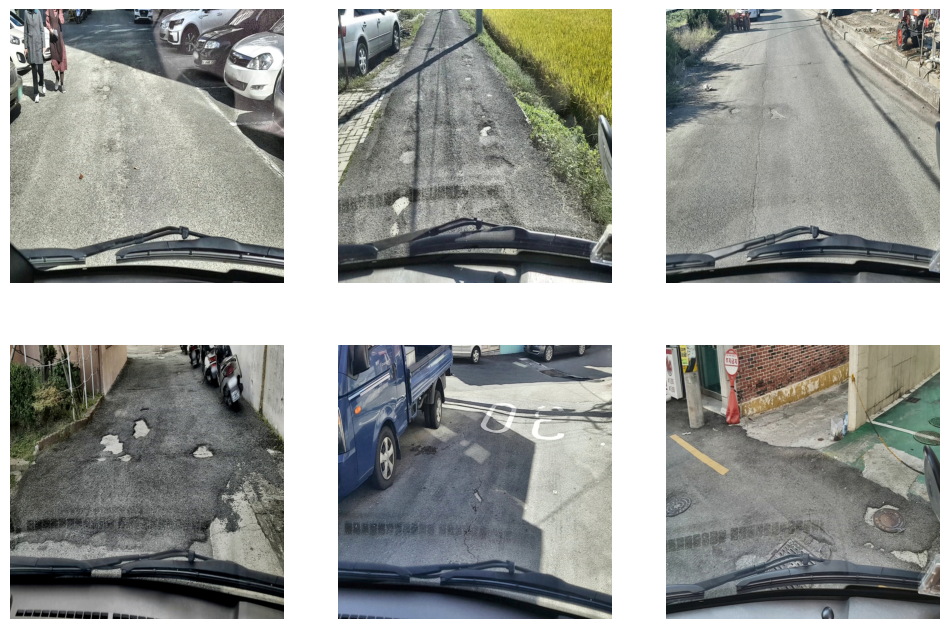

In [5]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob(os.path.join(image_dir, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return self.transform(img) if self.transform else img


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

train_loader = DataLoader(PotholeDataset(TRAIN_IMAGES, transform), batch_size=16, shuffle=True)
valid_loader = DataLoader(PotholeDataset(VALID_IMAGES, transform), batch_size=16, shuffle=False)


def show_sample_images(image_loader):
    sample_images = next(iter(image_loader))

    fig, ax = plt.subplots(2, 3, figsize=(12, 8))

    for i, img in enumerate(sample_images[:6]):
        ax[i // 3, i % 3].imshow(img.permute(1, 2, 0).numpy())
        ax[i // 3, i % 3].axis("off")

    plt.show()


print("훈련 데이터 샘플")
show_sample_images(train_loader)

## 5. 랜덤 샘플 시각화 (이미지 + 라벨)

학습 이미지 중 하나를 랜덤으로 선택하여 해당 이미지와 라벨 정보를 시각화합니다.  
라벨은 YOLO 포맷의 좌표 정보를 바탕으로 이미지 위에 바운딩 박스를 그려 확인합니다.


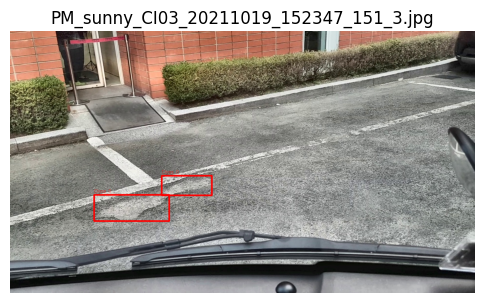

In [6]:
IMAGE_DIR = "/app/notebooks/pothole-detection-challenge_convert/train/images"
IMAGE_PATHS = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))

IMG_PATH = random.choice(IMAGE_PATHS)
LABEL_PATH = IMG_PATH.replace("images", "labels").replace(".jpg", ".txt")

img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

if os.path.exists(LABEL_PATH):
    with open(LABEL_PATH, "r") as f:
        for line in f.readlines():
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 5)
            cv2.putText(img, f"Class {int(cls)}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)
else:
    print("라벨 파일이 존재하지 않습니다:", LABEL_PATH)

# 시각화
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title(os.path.basename(IMG_PATH))
plt.show()

## 6. YOLO 모델 학습  
YOLO 모델을 불러와 학습을 수행하는 코드입니다.  
데이터셋 경로를 지정하고, 에포크 수 및 배치 크기를 설정하여 학습을 진행합니다.
- 기본적으로 YOLO 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장 경로를 직접 지정해야 합니다.
- `project` 및 `name` 파라미터를 사용하여 원하는 경로에 저장할 수 있습니다.

In [7]:

# 메모리 정리
torch.cuda.empty_cache()

In [8]:
model = YOLO("/app/notebooks/runs/pothole_yolo11s_result2/weights/best.pt")

# 학습 설정
DATA_YAML_PATH = "/app/notebooks/pothole-detection-challenge_convert/data.yaml"

train_args = {
    "data": DATA_YAML_PATH,
    "epochs": 100,
    "imgsz": 640,
    "batch": -1,
    "workers":4,
    "cos_lr":True,
    "device": 0,
    "optimizer": "AdamW",
    "lr0": 0.0005,
    "patience": 20,
    "project": "/app/notebooks/runs",
    "name": "pothole_yolov11m_best",
    "exist_ok": True,
    "amp": True
}

# 학습 재개
model.train(**train_args)




New https://pypi.org/project/ultralytics/8.3.127 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.122 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine/trainer: task=detect, mode=train, model=/app/notebooks/runs/pothole_yolo11s_result2/weights/best.pt, data=/app/notebooks/pothole-detection-challenge_convert/data.yaml, epochs=100, time=None, patience=20, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=/app/notebooks/runs, name=pothole_yolov11m_best, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False

100%|██████████| 755k/755k [00:00<00:00, 14.8MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

YOLO11s summary: 181 layers, 9,428,179 parameters, 9,428,163 gradients, 21.5 GFLOPs

Transferred 499/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 1.5±0.4 ms, read: 182.1±17.5 MB/s, size: 821.5 KB)


train: Scanning /app/notebooks/pothole-detection-challenge_convert/train/labels.cache... 24282 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24282/24282 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 0.13G reserved, 0.10G allocated, 9.77G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     9428179       21.55         0.828         72.94           363        (1, 3, 640, 640)                    list
     9428179        43.1         1.179          55.6         91.89        (2, 3, 640, 640)                    list
     9428179       86.19         1.726         28.04         86.28        (4, 3, 640, 640)                    list
     9428179       172.4         2.800          52.2         90.48        (8, 3, 640, 640)                    list
     9428179       34

train: Scanning /app/notebooks/pothole-detection-challenge_convert/train/labels.cache... 24282 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24282/24282 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.3±0.2 ms, read: 137.9±21.2 MB/s, size: 576.1 KB)


val: Scanning /app/notebooks/pothole-detection-challenge_convert/valid/labels.cache... 5998 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5998/5998 [00:00<?, ?it/s]


Plotting labels to /app/notebooks/runs/pothole_yolov11m_best/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00044531249999999996), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /app/notebooks/runs/pothole_yolov11m_best
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.73G      1.233     0.8124      0.985         89        640: 100%|██████████| 1278/1278 [03:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.48it/s]


                   all       5998      15797      0.818      0.718      0.819      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.75G      1.216     0.7979      0.982        118        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.76it/s]


                   all       5998      15797      0.841       0.71      0.821      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.75G      1.207     0.7888     0.9822         92        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.69it/s]

                   all       5998      15797      0.835      0.722      0.826      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.75G      1.213     0.7891     0.9853         87        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.62it/s]

                   all       5998      15797      0.834      0.714       0.82      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.75G        1.2     0.7795     0.9785         77        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.70it/s]

                   all       5998      15797      0.843      0.733      0.839      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.75G      1.196     0.7705     0.9772         55        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.64it/s]


                   all       5998      15797      0.844      0.743      0.845      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.75G      1.193     0.7636     0.9759         80        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.46it/s]


                   all       5998      15797      0.842      0.739      0.842      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.79G      1.177     0.7496       0.97         95        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.41it/s]

                   all       5998      15797       0.84      0.741      0.842      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.79G      1.171     0.7414     0.9671         49        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.81it/s]


                   all       5998      15797      0.847      0.754      0.853       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.79G      1.167     0.7328      0.966         85        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.68it/s]


                   all       5998      15797      0.851       0.75      0.855      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.79G      1.157     0.7281     0.9643         71        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.76it/s]

                   all       5998      15797       0.86      0.764      0.864      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.79G      1.152     0.7146     0.9623         73        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.73it/s]

                   all       5998      15797      0.849      0.767      0.862      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.79G      1.147     0.7074      0.959         98        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.71it/s]

                   all       5998      15797      0.865      0.767      0.868       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.79G      1.134     0.7003     0.9569        100        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.75it/s]


                   all       5998      15797      0.858      0.775       0.87      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.79G      1.132     0.6929     0.9545         71        640: 100%|██████████| 1278/1278 [02:46<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.77it/s]

                   all       5998      15797      0.861      0.779      0.873      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.79G      1.126     0.6896     0.9516         84        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.75it/s]

                   all       5998      15797      0.875      0.777      0.879      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.79G      1.122     0.6838     0.9518         68        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.72it/s]

                   all       5998      15797      0.868       0.79      0.882      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.79G      1.119     0.6781     0.9487        105        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:22<00:00,  7.16it/s]

                   all       5998      15797      0.875      0.791      0.886      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.79G      1.112     0.6723     0.9496         99        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:20<00:00,  7.54it/s]

                   all       5998      15797       0.88       0.79      0.888      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.79G      1.108     0.6672     0.9467         78        640: 100%|██████████| 1278/1278 [02:49<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:20<00:00,  7.54it/s]

                   all       5998      15797      0.882      0.795       0.89      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.79G      1.101     0.6589     0.9435         70        640: 100%|██████████| 1278/1278 [02:49<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:20<00:00,  7.54it/s]

                   all       5998      15797      0.881      0.798      0.893      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.79G      1.096     0.6557     0.9436         77        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.76it/s]

                   all       5998      15797      0.884      0.797      0.892      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.79G      1.086     0.6484     0.9384         90        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.80it/s]

                   all       5998      15797      0.887      0.803      0.897      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.79G      1.082     0.6447     0.9394         70        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.77it/s]

                   all       5998      15797      0.885      0.806      0.899      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.79G      1.081     0.6411     0.9363        113        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.76it/s]

                   all       5998      15797      0.889      0.808      0.901      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.79G      1.076     0.6368     0.9346        130        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.77it/s]

                   all       5998      15797      0.884      0.811      0.902      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.79G      1.073     0.6303     0.9341        102        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.70it/s]

                   all       5998      15797       0.89      0.813      0.904      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.79G      1.073     0.6289      0.936         90        640: 100%|██████████| 1278/1278 [02:47<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.79it/s]

                   all       5998      15797      0.888      0.817      0.905      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.79G      1.068      0.626      0.932         81        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.63it/s]

                   all       5998      15797       0.89      0.816      0.906      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.79G       1.06     0.6171     0.9307         85        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:20<00:00,  7.58it/s]

                   all       5998      15797      0.885      0.821      0.907      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.79G      1.058     0.6156     0.9299         67        640: 100%|██████████| 1278/1278 [02:49<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.41it/s]

                   all       5998      15797      0.885      0.823      0.907      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.79G       1.05     0.6093     0.9271        107        640: 100%|██████████| 1278/1278 [02:57<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.38it/s]

                   all       5998      15797      0.888       0.82      0.909      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.79G      1.045     0.6052     0.9248        119        640: 100%|██████████| 1278/1278 [02:57<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:25<00:00,  6.24it/s]

                   all       5998      15797      0.888      0.824      0.909      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.79G       1.04     0.5998     0.9243         94        640: 100%|██████████| 1278/1278 [02:55<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:25<00:00,  6.23it/s]


                   all       5998      15797      0.889      0.825       0.91       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.79G      1.038     0.5983     0.9236         84        640: 100%|██████████| 1278/1278 [02:58<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:22<00:00,  6.97it/s]

                   all       5998      15797      0.894      0.824      0.911      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.79G      1.035     0.5954     0.9219         88        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:20<00:00,  7.54it/s]

                   all       5998      15797      0.893      0.824      0.911      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.79G      1.033     0.5923     0.9223         91        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.34it/s]

                   all       5998      15797      0.893      0.825      0.912      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.79G      1.029     0.5913       0.92         97        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.32it/s]

                   all       5998      15797      0.892      0.825      0.912      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.79G      1.021     0.5803     0.9185        106        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.33it/s]

                   all       5998      15797      0.893      0.825      0.913      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.79G      1.016     0.5795     0.9159         89        640: 100%|██████████| 1278/1278 [02:55<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.72it/s]

                   all       5998      15797      0.895      0.827      0.913      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.79G      1.019     0.5779     0.9176         86        640: 100%|██████████| 1278/1278 [02:49<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.56it/s]

                   all       5998      15797      0.896      0.827      0.913      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.79G      1.015     0.5735     0.9159         72        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.34it/s]

                   all       5998      15797      0.898      0.826      0.914      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.79G      1.011     0.5703     0.9135         73        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.63it/s]

                   all       5998      15797      0.898      0.827      0.914      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.79G      1.001     0.5647     0.9112         81        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.77it/s]

                   all       5998      15797      0.899      0.827      0.915      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.79G     0.9985     0.5594     0.9114         62        640: 100%|██████████| 1278/1278 [02:49<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.40it/s]

                   all       5998      15797        0.9      0.826      0.915      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.79G     0.9947     0.5577     0.9101         70        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.63it/s]

                   all       5998      15797      0.899      0.828      0.915      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.79G     0.9938     0.5546     0.9094        118        640: 100%|██████████| 1278/1278 [02:49<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.46it/s]

                   all       5998      15797      0.901      0.828      0.915       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.79G      0.987     0.5515     0.9082        140        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.65it/s]

                   all       5998      15797      0.901      0.828      0.915       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.79G     0.9825     0.5488      0.907        137        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.67it/s]

                   all       5998      15797        0.9      0.828      0.916       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.79G     0.9816     0.5463     0.9072         87        640: 100%|██████████| 1278/1278 [02:49<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.60it/s]

                   all       5998      15797      0.901      0.829      0.916      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.79G     0.9767     0.5428     0.9056         82        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.73it/s]

                   all       5998      15797      0.901      0.832      0.917      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.79G     0.9707     0.5374     0.9044         69        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:25<00:00,  6.27it/s]

                   all       5998      15797      0.902      0.832      0.917      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.79G     0.9696     0.5367      0.902        114        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.38it/s]

                   all       5998      15797        0.9      0.833      0.917      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.79G     0.9643     0.5324     0.9029         83        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.63it/s]

                   all       5998      15797      0.901      0.833      0.917      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.79G     0.9599     0.5315     0.9009         94        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.66it/s]

                   all       5998      15797      0.901      0.833      0.917      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.79G     0.9568     0.5268     0.8993        125        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:22<00:00,  7.05it/s]

                   all       5998      15797      0.901      0.834      0.918      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.79G     0.9568     0.5252     0.8996        101        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:22<00:00,  7.01it/s]

                   all       5998      15797      0.902      0.834      0.918      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.79G     0.9539     0.5219     0.8969        108        640: 100%|██████████| 1278/1278 [02:55<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.52it/s]

                   all       5998      15797      0.902      0.834      0.918      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.79G     0.9512     0.5191     0.8975         89        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.21it/s]

                   all       5998      15797      0.903      0.834      0.918      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.79G     0.9451     0.5161     0.8958         87        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.43it/s]

                   all       5998      15797      0.904      0.834      0.918      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.79G     0.9412     0.5117     0.8948        134        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.52it/s]

                   all       5998      15797      0.903      0.834      0.918      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.79G     0.9387     0.5124     0.8945         77        640: 100%|██████████| 1278/1278 [02:54<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.47it/s]

                   all       5998      15797      0.902      0.836      0.919      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.79G     0.9357     0.5095     0.8937         65        640: 100%|██████████| 1278/1278 [03:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.38it/s]

                   all       5998      15797      0.905      0.834      0.919      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.79G     0.9303     0.5045     0.8926         90        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.58it/s]

                   all       5998      15797      0.905      0.834      0.919      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.79G     0.9278     0.5009     0.8922         81        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.80it/s]

                   all       5998      15797      0.905      0.834      0.919      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.79G     0.9261     0.5008     0.8904         77        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.76it/s]

                   all       5998      15797      0.907      0.833      0.919      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.79G     0.9244     0.4996     0.8908         85        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.76it/s]

                   all       5998      15797      0.908      0.832      0.919      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.79G     0.9184     0.4952     0.8896         89        640: 100%|██████████| 1278/1278 [02:46<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:22<00:00,  6.92it/s]

                   all       5998      15797      0.907      0.833      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.79G     0.9153     0.4922     0.8895         73        640: 100%|██████████| 1278/1278 [02:46<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.48it/s]

                   all       5998      15797      0.906      0.835      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.79G     0.9131     0.4914     0.8889         58        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.46it/s]

                   all       5998      15797      0.907      0.834      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.79G     0.9105     0.4903     0.8867         79        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.52it/s]

                   all       5998      15797      0.908      0.834      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.79G     0.9095     0.4917     0.8863         89        640: 100%|██████████| 1278/1278 [02:54<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.47it/s]

                   all       5998      15797      0.908      0.834      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.79G     0.9043     0.4847     0.8863         80        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.44it/s]

                   all       5998      15797      0.909      0.834      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.79G     0.9005     0.4823      0.884         89        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:20<00:00,  7.55it/s]

                   all       5998      15797      0.908      0.834      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.79G     0.8985     0.4814     0.8847         94        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:20<00:00,  7.57it/s]

                   all       5998      15797      0.908      0.834      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.79G     0.9013     0.4824     0.8841         72        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.71it/s]

                   all       5998      15797      0.908      0.835      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.79G     0.8985     0.4798      0.884        108        640: 100%|██████████| 1278/1278 [02:49<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.49it/s]

                   all       5998      15797      0.907      0.836      0.919      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.79G     0.8916     0.4766     0.8812         69        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:22<00:00,  6.88it/s]

                   all       5998      15797      0.904      0.839      0.919      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.79G     0.8898      0.475     0.8812         86        640: 100%|██████████| 1278/1278 [02:46<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.33it/s]

                   all       5998      15797      0.905      0.838      0.919      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.79G      0.886     0.4734     0.8817         99        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.41it/s]

                   all       5998      15797      0.906      0.838      0.919      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.79G     0.8854     0.4708     0.8815         80        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.53it/s]

                   all       5998      15797      0.906      0.836      0.919      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.79G     0.8858      0.472     0.8806         80        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.77it/s]

                   all       5998      15797      0.906      0.837      0.919      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.79G     0.8855     0.4719     0.8807        138        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.44it/s]

                   all       5998      15797      0.906      0.837      0.919      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.79G     0.8789     0.4683     0.8799         68        640: 100%|██████████| 1278/1278 [02:56<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.23it/s]

                   all       5998      15797      0.907      0.837      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.79G     0.8833     0.4687     0.8786         96        640: 100%|██████████| 1278/1278 [02:57<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.28it/s]

                   all       5998      15797      0.906      0.838      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.79G     0.8794     0.4667     0.8792         91        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:20<00:00,  7.57it/s]

                   all       5998      15797      0.905      0.838      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.79G     0.8766     0.4645     0.8776         64        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.44it/s]

                   all       5998      15797      0.905      0.838      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.79G     0.8783     0.4663     0.8792         98        640: 100%|██████████| 1278/1278 [02:54<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.38it/s]

                   all       5998      15797      0.907      0.837      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.79G     0.8762     0.4663     0.8776        114        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.52it/s]

                   all       5998      15797      0.907      0.837      0.919      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.79G     0.8744     0.4642     0.8781         96        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.56it/s]

                   all       5998      15797      0.907      0.838      0.919      0.658


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.79G     0.8578      0.442     0.8749         61        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.57it/s]

                   all       5998      15797      0.909      0.837       0.92      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.79G     0.8414     0.4309     0.8711         52        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.53it/s]

                   all       5998      15797      0.909      0.838       0.92      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.79G     0.8359     0.4274     0.8706         34        640: 100%|██████████| 1278/1278 [02:49<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.73it/s]

                   all       5998      15797      0.908      0.839       0.92      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.79G     0.8332     0.4255     0.8689         48        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:24<00:00,  6.48it/s]


                   all       5998      15797      0.907      0.839      0.919      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.79G     0.8287     0.4233     0.8675         48        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.67it/s]

                   all       5998      15797      0.907      0.839       0.92      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.79G     0.8302     0.4237     0.8678         48        640: 100%|██████████| 1278/1278 [02:50<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:23<00:00,  6.67it/s]

                   all       5998      15797      0.907      0.839      0.919      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.79G     0.8291     0.4216     0.8673         34        640: 100%|██████████| 1278/1278 [02:48<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.32it/s]

                   all       5998      15797      0.909      0.838      0.919      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.79G     0.8265     0.4207     0.8678         51        640: 100%|██████████| 1278/1278 [02:52<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:22<00:00,  7.11it/s]

                   all       5998      15797      0.905       0.84       0.92      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.79G     0.8249     0.4202     0.8666         49        640: 100%|██████████| 1278/1278 [02:53<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:21<00:00,  7.35it/s]

                   all       5998      15797      0.907       0.84       0.92       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.79G     0.8261     0.4215     0.8663         57        640: 100%|██████████| 1278/1278 [02:51<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:25<00:00,  6.18it/s]

                   all       5998      15797      0.905       0.84      0.919       0.66



100 epochs completed in 5.410 hours.
Optimizer stripped from /app/notebooks/runs/pothole_yolov11m_best/weights/last.pt, 19.2MB
Optimizer stripped from /app/notebooks/runs/pothole_yolov11m_best/weights/best.pt, 19.2MB

Validating /app/notebooks/runs/pothole_yolov11m_best/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [00:26<00:00,  5.99it/s]


                   all       5998      15797      0.906       0.84       0.92      0.659
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /app/notebooks/runs/pothole_yolov11m_best


SyntaxError: '[31m[1mtta[0m' is not a valid YOLO argument. 

    Arguments received: ['yolo', '-f', '/root/.local/share/jupyter/runtime/kernel-9a53b820-b2e8-47e9-8dec-251265470b88.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of frozenset({'segment', 'detect', 'classify', 'pose', 'obb'})
                MODE (required) is one of frozenset({'val', 'predict', 'export', 'benchmark', 'train', 'track'})
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco8.yaml model=yolo11n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolo11n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolo11n.pt data=coco8.yaml batch=1 imgsz=640

    4. Export a YOLO11n classification model to ONNX format at image size 224 by 128 (no TASK required)
        yolo export model=yolo11n-cls.pt format=onnx imgsz=224,128

    5. Ultralytics solutions usage
        yolo solutions count or in ['crop', 'blur', 'workout', 'heatmap', 'isegment', 'visioneye', 'speed', 'queue', 'analytics', 'inference', 'trackzone'] source="path/to/video.mp4"

    6. Run special commands:
        yolo help
        yolo checks
        yolo version
        yolo settings
        yolo copy-cfg
        yolo cfg
        yolo solutions help

    Docs: https://docs.ultralytics.com
    Solutions: https://docs.ultralytics.com/solutions/
    Community: https://community.ultralytics.com
    GitHub: https://github.com/ultralytics/ultralytics
     (<string>)

## 7. 학습 결과 시각화

YOLO 모델 학습 과정에서 저장된 손실 그래프(`results.png`)를 불러와 시각화하는 코드입니다.  
`matplotlib`을 사용하여 이미지를 출력하고, 그래프 외 요소는 제거하여 깔끔하게 보여줍니다.

- 기본적으로 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장된 경로를 명시적으로 지정해주어야 합니다.


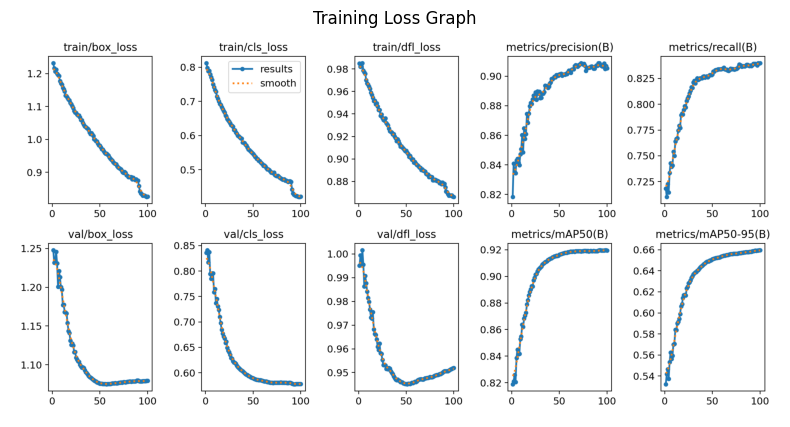

In [10]:
TRAIN_RUN_DIR = "/app/notebooks/runs/pothole_yolov11m_best"
loss_plot_path = f"{TRAIN_RUN_DIR}/results.png"

img = plt.imread(loss_plot_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Training Loss Graph")
plt.show()

## 8. 모델 성능 평가  
학습된 YOLO 모델을 불러와 검증 데이터셋을 이용해 성능을 평가하는 코드입니다.  
`val()` 함수를 사용하여 `mAP`, `Precision`, `Recall` 등의 성능 지표를 계산합니다.

- 캐글 환경에서는 모델이 저장된 경로를 지정해줘야 합니다.


In [16]:
# 학습 후 검증 데이터 평가
val_results = model.val(data=DATA_YAML_PATH, split="val", conf=0.005, device="cuda")

# 결과 출력
print("검증 데이터 평가 결과 :")
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")

Ultralytics 8.3.122 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
val: Fast image access ✅ (ping: 0.7±0.0 ms, read: 250.0±32.3 MB/s, size: 665.1 KB)


val: Scanning /app/notebooks/pothole-detection-challenge_convert/valid/labels.cache... 5998 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5998/5998 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:32<00:00, 11.45it/s]


                   all       5998      15797      0.907      0.839       0.92      0.667
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val54
검증 데이터 평가 결과 :
mAP50: 0.9200
mAP50-95: 0.6672
Precision: 0.9074
Recall: 0.8393


## 9. 모델 추론 및 시각화
학습된 YOLO 모델을 사용하여 테스트 데이터셋에서 임의의 이미지를 추론합니다.

- 포트홀을 감지하지 못하면 아무것도 표시되지 않습니다.


image 1/1 /app/notebooks/pothole-detection-challenge_convert/test/images/PM_wetsunny_CI02_20211021_152554_423_2.jpg: 384x640 1 pothole, 45.9ms
Speed: 1.6ms preprocess, 45.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


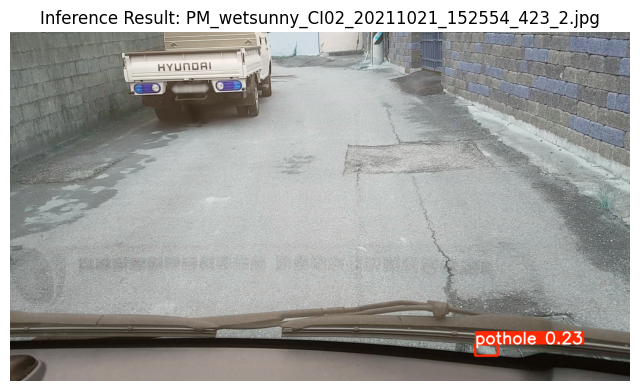

In [12]:
model = YOLO("/app/notebooks/runs/pothole_yolov11m_best/weights/best.pt")

TEST_IMAGE_DIR = "/app/notebooks/pothole-detection-challenge_convert/test/images"
test_image_paths = sorted(glob(os.path.join(TEST_IMAGE_DIR, "*.jpg")))
test_img_path = random.choice(test_image_paths)

results = model.predict(source=test_img_path, conf=0.1, imgsz=640, save=False)

result_img = results[0].plot()

plt.figure(figsize=(8, 6))
plt.imshow(result_img)
plt.axis("off")
plt.title(f"Inference Result: {os.path.basename(test_img_path)}")
plt.show()

## 10. 제출 파일 생성 (submission.csv)
테스트 이미지에 대해 학습된 YOLO 모델을 사용하여 객체 탐지를 수행하고,  
예측 결과를 제출 형식에 맞춰 `submission.csv` 파일로 저장합니다.

- 한 이미지당 박스 하나만 제출하며, confidence가 가장 높은 박스를 사용합니다.
- 객체를 감지하지 못한 경우, `ClassId`와 바운딩 박스 좌표는 모두 0으로 처리합니다.
- 이미지가 손상되었거나 열리지 않는 경우에도 에러 없이 넘어가도록 예외 처리를 포함합니다.
- Output 경로인 /kagggle/working/에 저장됩니다.

In [13]:
import pandas as pd

model = YOLO("/app/notebooks/runs/pothole_yolov11m_best/weights/best.pt")

TEST_IMG_DIR = "/app/notebooks/pothole-detection-challenge_convert/test/images"
test_image_paths = sorted(glob(os.path.join(TEST_IMG_DIR, "*.jpg")))

submission_rows = []

for img_path in test_image_paths:
    image_id = os.path.basename(img_path)

    if cv2.imread(img_path) is None:
        print(f"이미지 로드 실패: {image_id}")
        submission_rows.append({
            "ImageId": image_id,
            "ClassId": 0,
            "X": 0,
            "Y": 0,
            "Width": 0,
            "Height": 0,
        })
        continue

    results = model.predict(source=img_path, conf=0.0042, imgsz=640, save=False)
    result = results[0]

    if len(result.boxes) > 0:
        boxes = result.boxes
        best_idx = boxes.conf.argmax().item()
        cls_id = int(boxes.cls[best_idx].item())
        cx, cy, w, h = boxes.xywhn[best_idx].tolist()

        submission_rows.append({
            "ImageId": image_id,
            "ClassId": cls_id,
            "X": round(cx, 6),
            "Y": round(cy, 6),
            "Width": round(w, 6),
            "Height": round(h, 6),
        })
    else:
        submission_rows.append({
            "ImageId": image_id,
            "ClassId": 0,
            "X": 0,
            "Y": 0,
            "Width": 0,
            "Height": 0,
        })

submission_df = pd.DataFrame(submission_rows, columns=["ImageId", "ClassId", "X", "Y", "Width", "Height"])
submission_path = "/app/notebooks/submission_prepro.csv"
submission_df.to_csv(submission_path, index=False)
print(f"제출 파일 저장 완료: {submission_path}")


image 1/1 /app/notebooks/pothole-detection-challenge_convert/test/images/AM_sunny_CI01_20210916_105931_11_117_2.jpg: 384x640 6 potholes, 23.8ms
Speed: 2.3ms preprocess, 23.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /app/notebooks/pothole-detection-challenge_convert/test/images/AM_sunny_CI01_20210916_105931_11_118_2.jpg: 384x640 1 pothole, 4.4ms
Speed: 1.4ms preprocess, 4.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /app/notebooks/pothole-detection-challenge_convert/test/images/AM_sunny_CI01_20210916_105931_11_134_1.jpg: 384x640 10 potholes, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /app/notebooks/pothole-detection-challenge_convert/test/images/AM_sunny_CI01_20210916_105931_11_137_2.jpg: 384x640 5 potholes, 4.8ms
Speed: 1.4ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /app/notebooks/pothole-dete